<Axes: >

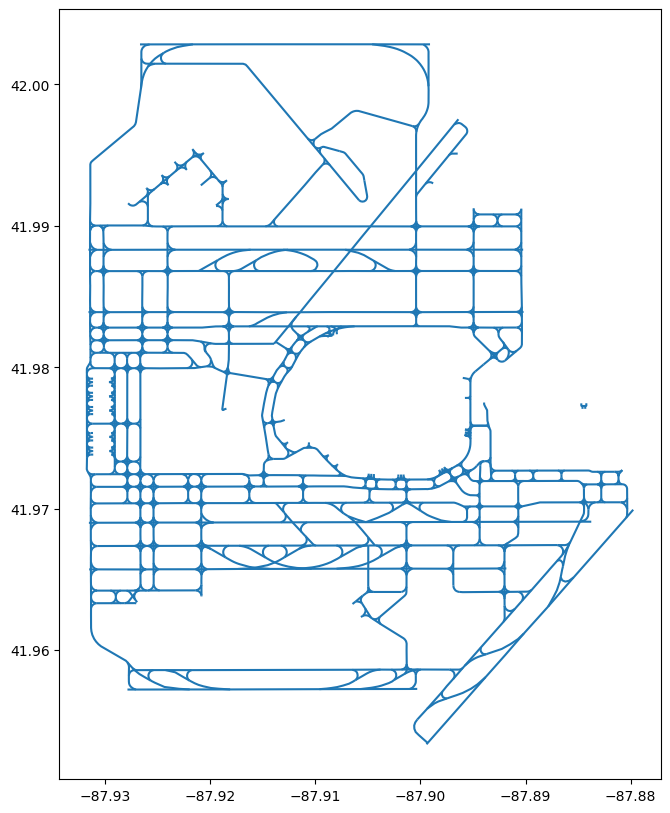

In [5]:
import osmnx as ox

# defines tags and place
tags = {"aeroway": ["taxiway", "runway"]}
place = "O'Hare International Airport, Chicago, Illinois, USA"

# gets geospatial data
gdf = ox.features_from_place(place, tags)

gdf.plot(figsize=(10, 10))

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import LineString

def plot_runway_checkpoints(place_name):
    """
    Plots runways and their start/end points for a given airport.
    
    Args:
        place_name (str): Name of the airport (e.g., "O'Hare International Airport, Chicago, IL")
    """

    # Define tags and get geospatial data for the place
    tags = {"aeroway": ["taxiway", "runway"]}
    gdf = ox.features_from_place(place_name, tags)

    # Filter for runway only
    runways = gdf[gdf["aeroway"] == "runway"]

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color='lightgray')

    # Loops through each runway and extract endpoints
    # For each runway, it checks if it is a LineString (most are),
    # it extracts the first and last coordinate pair from the line and plots them
    for idx, row in runways.iterrows():
        geom = row.geometry
        if isinstance(geom, LineString):
            start = geom.coords[0]
            end = geom.coords[-1]

            # Plot start and end
            ax.plot(start[0], start[1], 'ro')  # red = start
            ax.plot(end[0], end[1], 'go')      # green = end

            # Optional labels
            ax.text(start[0], start[1], 'Start', fontsize=8, color='red')
            ax.text(end[0], end[1], 'End', fontsize=8, color='green')

    plt.title(f"Runways with Auto-Detected Start/End Checkpoints\n{place_name}")
    plt.show()

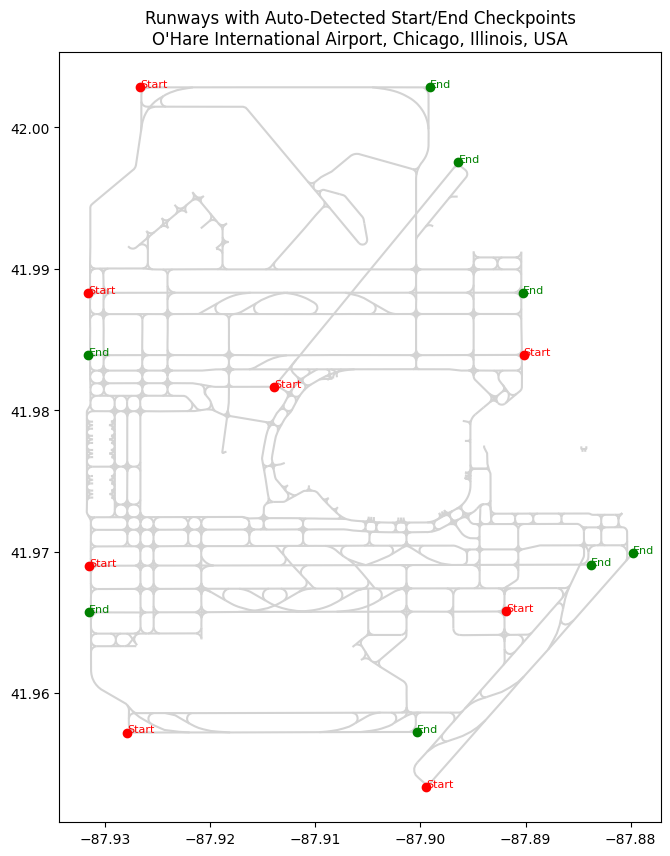

In [3]:
plot_runway_checkpoints("O'Hare International Airport, Chicago, Illinois, USA")

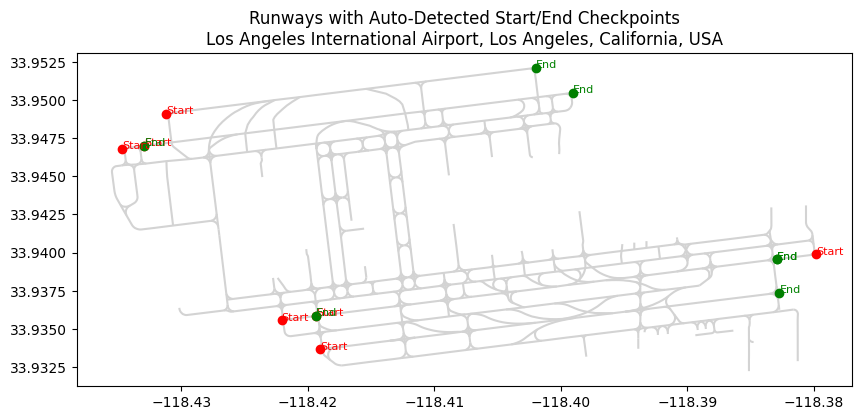

In [4]:
plot_runway_checkpoints("Los Angeles International Airport, Los Angeles, California, USA")

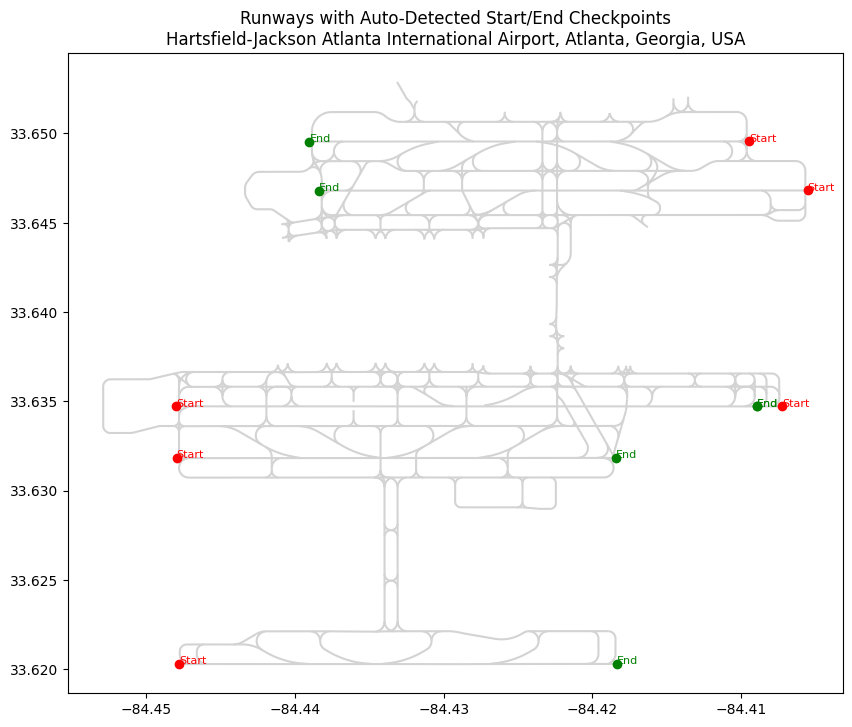

In [5]:
plot_runway_checkpoints("Hartsfield-Jackson Atlanta International Airport, Atlanta, Georgia, USA")